In [39]:
!pip install matplotlib
!pip install optimum
!pip install onnxruntime
!pip install onnx
!pip install cupy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached cupy-13.3.0.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      Generating cache key from header files...
      Cache key (1610 files matching /private/var/folders/l1/xn4zqt856pd5q_jbvzm1xkz00000gn/T/pip-install-r417escw/cupy_79e3bdd8e76648ebabcd8a4d585fbb95/cupy/_core/include/**): 9495fdb044226d6afceec17bcdb39ffea36b00e0
      Error: macOS is no longer supported
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [40]:
import pandas as pd
import torch
import time
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from optimum.onnxruntime import (
    AutoQuantizationConfig,
    ORTModelForSequenceClassification,
    ORTQuantizer
)
from optimum.pipelines import pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a Dummy DataFrame for Fine-tuning
data = {
    "text": [
        "I bought a new laptop",
        "The product is great",
        "I want to return this item",
        "Amazing customer service",
        "I had a terrible experience",
        "Great product but expensive",
        "Worst purchase ever"
    ],
    "label": [1, 0, 1, 0, 1, 0, 1]  # 1: Purchase-related, 0: Non-purchase-related
}

df = pd.DataFrame(data)

In [41]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import time

# Convert the DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize_function, batched=True)

# Train-test split
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()


# Cargar el tokenizer y el modelo preentrenado
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenizar el texto
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=1,              # Número de épocas
    per_device_train_batch_size=16,   # Tamaño del batch por dispositivo
    logging_dir='./logs',            # Directorio de logs
    logging_steps=10,
)

# Definir el Trainer
trainer = Trainer(
    model=model,                         # El modelo a fine-tunear
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Dataset de entrenamiento
)

# Medir el tiempo de entrenamiento
start_time = time.time()

# Fine-tunear el modelo
trainer.train()

end_time = time.time()

# Guardar el tiempo de fine-tuning
training_time = end_time - start_time

print(f"Tiempo de fine-tuning: {training_time:.2f} segundos")

Map: 100%|██████████| 7/7 [00:00<00:00, 975.16 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1/1 [00:06<00:00,  6.47s/it]

{'train_runtime': 6.4692, 'train_samples_per_second': 0.773, 'train_steps_per_second': 0.155, 'train_loss': 0.6979730725288391, 'epoch': 1.0}
Tiempo de fine-tuning: 6.86 segundos


In [42]:
# Save the fine-tuned model
fine_tuned_model_dir = "./distilbert_finetuned"
model.save_pretrained(fine_tuned_model_dir)
tokenizer.save_pretrained(fine_tuned_model_dir)

('./distilbert_finetuned/tokenizer_config.json',
 './distilbert_finetuned/special_tokens_map.json',
 './distilbert_finetuned/vocab.txt',
 './distilbert_finetuned/added_tokens.json')

In [43]:
# Step 3: Export the fine-tuned model to ONNX
onnx_save_dir = "distilbert_finetuned_onnx"
ort_model = ORTModelForSequenceClassification.from_pretrained(fine_tuned_model_dir, export=True)

# Save the ONNX model
ort_model.save_pretrained(onnx_save_dir)

In [44]:
# Step 4: Quantize the model
from optimum.onnxruntime import AutoQuantizationConfig, ORTQuantizer

# Load the fine-tuned ONNX model
qconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=True)
quantizer = ORTQuantizer.from_pretrained(onnx_save_dir)

# Quantize the model
quantizer.quantize(save_dir="distilbert_finetuned_quantized", quantization_config=qconfig)

# Load the quantized model
quantized_model = ORTModelForSequenceClassification.from_pretrained("distilbert_finetuned_quantized")

Fine-tuned model inference time: 0.0078 seconds
ONNX model inference time: 0.0082 seconds
Quantized model inference time: 0.0039 seconds


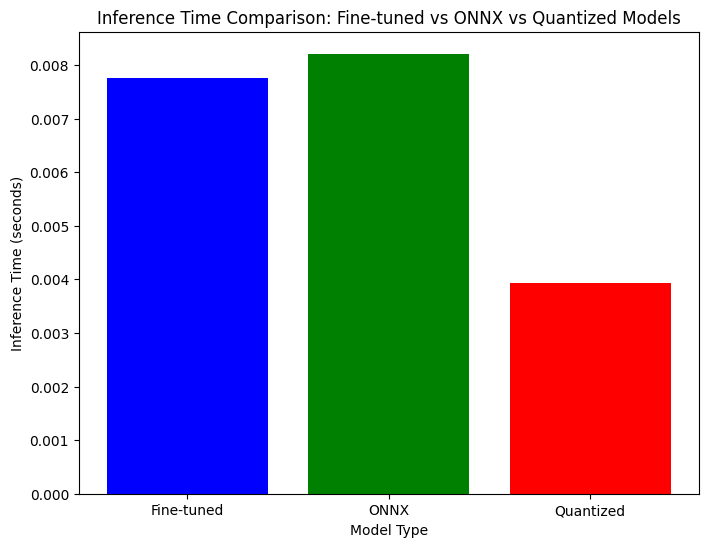

In [46]:
# Step 5: Measure Inference Time for Fine-tuned Model
onnx_clx_finetuned = pipeline("text-classification", model=fine_tuned_model_dir)
start_time = time.time()
pred_finetuned = onnx_clx_finetuned("I bought a new laptop")
finetuned_inference_time = time.time() - start_time
print(f"Fine-tuned model inference time: {finetuned_inference_time:.4f} seconds")

# Step 6: Measure Inference Time for ONNX Model
onnx_clx = pipeline("text-classification", model=onnx_save_dir, accelerator="ort")
start_time = time.time()
pred_onnx = onnx_clx("I bought a new laptop")
onnx_inference_time = time.time() - start_time
print(f"ONNX model inference time: {onnx_inference_time:.4f} seconds")

# Step 7: Measure Inference Time for Quantized Model
onnx_clx_quantized = pipeline("text-classification", model=quantized_model, accelerator="ort")
start_time = time.time()
pred_quantized = onnx_clx_quantized("I bought a new laptop")
quantized_inference_time = time.time() - start_time
print(f"Quantized model inference time: {quantized_inference_time:.4f} seconds")

# Step 8: Compare and Graph Inference Times
models = ['Fine-tuned', 'ONNX', 'Quantized']
inference_times = [finetuned_inference_time, onnx_inference_time, quantized_inference_time]

plt.figure(figsize=(8, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Fine-tuned vs ONNX vs Quantized Models')
plt.show()